In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from stop_words import get_stop_words
from collections import Counter
from fitter import Fitter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
df = pd.read_csv("../data/corpora_dataset.csv",sep=";", encoding='utf8')

In [3]:
remove_stop_words = False
remove_punctuations = True
to_lower = False
vocab_size = 10000
embedding_dim = 4
sentence_length_threshold = 35
learning_rate = 0.001

In [4]:
trunc_type='post'
padding_type='post'
optimizer = Adam(learning_rate=learning_rate)
loss_function = 'binary_crossentropy'
train_metric = "accuracy"
num_epochs = 30
early_stopping_patience = 3

In [5]:
if remove_stop_words:

    titles = df['titles'].to_list()

    stop = get_stop_words('italian')

    for i in range(len(titles)):

        titles[i]  = ' '.join([i for i in titles[i].split() if i not in stop])

    df["titles"] = titles

In [6]:
sentences = df['titles'].values
labels = df['Label'].values

training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(sentences, labels, test_size=0.2)

print(f"Traning Set Size: {len(training_sentences)}")
print(f"Test Set Size: {len(testing_sentences)}")

if remove_punctuations:
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>", lower=to_lower)
else:
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>", lower=to_lower, filters='')

tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

Traning Set Size: 12408
Test Set Size: 3102


In [7]:
print(f"Training Set Word Count: {len(word_index)}")

Training Set Word Count: 32347


In [8]:
lengths = []

for sentences in training_sentences:
    
    sen_len = len(sentences.split())
    
    lengths.append(sen_len)

In [9]:
print(f"\nSentences;\nMin Length: {min(lengths)}\nMax Length: {max(lengths)}\nMean Length: {(sum(lengths) / len(lengths))}\nSTD of Lengths: {np.std(lengths)}")


Sentences;
Min Length: 4
Max Length: 36
Mean Length: 15.633059316569955
STD of Lengths: 4.484394452588958


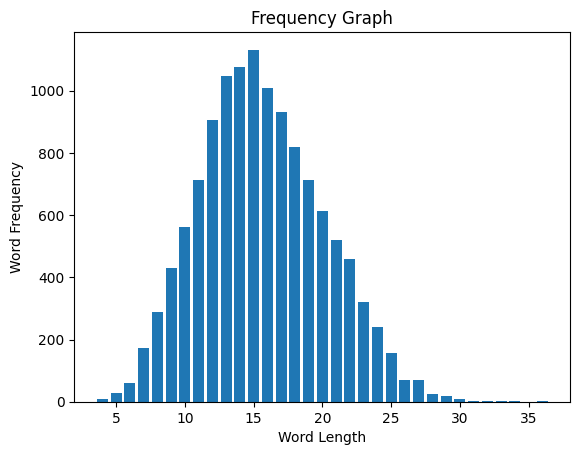

In [10]:
frequency = Counter(lengths)

labels, counts = zip(*frequency.items())

plt.bar(labels, counts)
plt.xlabel('Word Length')
plt.ylabel('Word Frequency')
plt.title('Frequency Graph')
plt.show()

In [11]:
if sentence_length_threshold != -1:
    print(f"\nSentence Lenght Threshold overrided: {sentence_length_threshold}")
else:
    sentence_length_threshold = int((sum(lengths) / len(lengths)) + (3 * np.std(lengths)))
    print(f"\nEven if data has not normal distribution but we can take sentence length_threshold as Mean+3std: {sentence_length_threshold}")


Sentence Lenght Threshold overrided: 35


In [12]:
count = 0

for i in lengths:
    
    if i <= sentence_length_threshold:
        count+=1

print(f"\nWe cover {(count/len(lengths)*100):.2f}% of the sentences without losing an information. Expectation of normal distribution is 99.7%.")


We cover 99.99% of the sentences without losing an information. Expectation of normal distribution is 99.7%.


In [13]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=sentence_length_threshold, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=sentence_length_threshold, padding=padding_type, truncating=trunc_type)

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [14]:
model = Sequential([
    Embedding(vocab_size, embedding_dim),
    LSTM(16, return_sequences=False),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss=loss_function, optimizer=optimizer, metrics=[train_metric])

early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)

print()

print("Train Started.")

start_time = time.time()

history = model.fit(
    training_padded, training_labels,
    epochs=num_epochs,
    validation_data=(testing_padded, testing_labels),
    callbacks=[early_stopping],
    verbose=2
)

end_time = time.time()

print("Train Ended.")

training_time = (end_time - start_time)

print(f"\nTraining time: {training_time} seconds.")


Train Started.
Epoch 1/30
388/388 - 5s - 14ms/step - accuracy: 0.6610 - loss: 0.5656 - val_accuracy: 0.8691 - val_loss: 0.3866
Epoch 2/30
388/388 - 3s - 8ms/step - accuracy: 0.8941 - loss: 0.3557 - val_accuracy: 0.9097 - val_loss: 0.3338
Epoch 3/30
388/388 - 3s - 7ms/step - accuracy: 0.9298 - loss: 0.2696 - val_accuracy: 0.9252 - val_loss: 0.3028
Epoch 4/30
388/388 - 3s - 7ms/step - accuracy: 0.9413 - loss: 0.2192 - val_accuracy: 0.9271 - val_loss: 0.2826
Epoch 5/30
388/388 - 3s - 7ms/step - accuracy: 0.9485 - loss: 0.1896 - val_accuracy: 0.9233 - val_loss: 0.2667
Epoch 6/30
388/388 - 3s - 7ms/step - accuracy: 0.9555 - loss: 0.1641 - val_accuracy: 0.9288 - val_loss: 0.2961
Epoch 7/30
388/388 - 3s - 7ms/step - accuracy: 0.9560 - loss: 0.1565 - val_accuracy: 0.9288 - val_loss: 0.2796
Epoch 8/30
388/388 - 3s - 7ms/step - accuracy: 0.9616 - loss: 0.1362 - val_accuracy: 0.9236 - val_loss: 0.4424
Train Ended.

Training time: 24.863223552703857 seconds.


In [15]:
def acc_loss_plots(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.axvline(x=stopped_epoch, color='r', linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string, "early_stop_epoch"])
    plt.show()

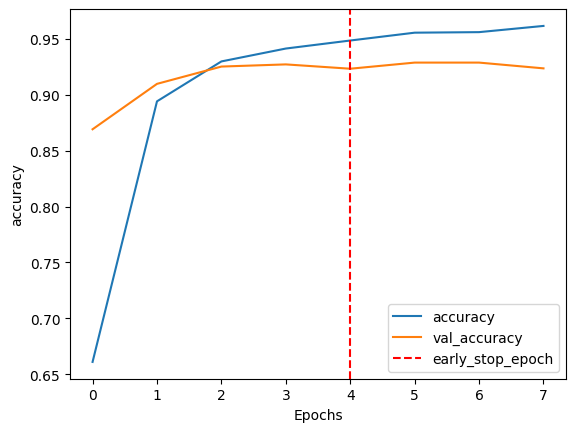

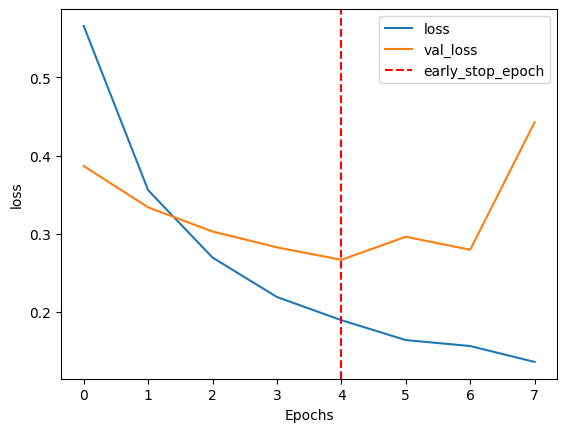

In [16]:
stopped_epoch = early_stopping.stopped_epoch - early_stopping_patience

acc_loss_plots(history, "accuracy")
acc_loss_plots(history, "loss")

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


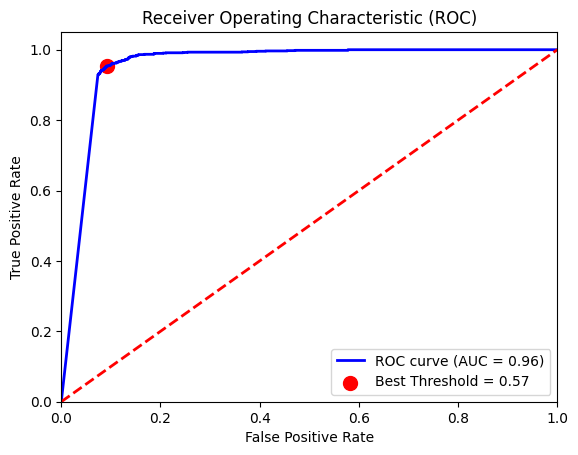

In [17]:
y_pred_prob = model.predict(testing_padded)

auc_score = roc_auc_score(testing_labels, y_pred_prob)

fpr, tpr, thresholds = roc_curve(testing_labels, y_pred_prob)

best_index = np.argmax(tpr-fpr)
best_threshold = thresholds[best_index]
best_tpr = tpr[best_index]
best_fpr = fpr[best_index]

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.scatter(best_fpr, best_tpr, color='red', label=f'Best Threshold = {best_threshold:.2f}', s=100)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [18]:
print(f"We used cut off threshold {best_threshold:.2f}")

We used cut off threshold 0.57


In [19]:
y_pred = (y_pred_prob > best_threshold).astype(int)

report = classification_report(testing_labels, y_pred)

print("\nClassification Report for Test Data:\n\n", report)


Classification Report for Test Data:

               precision    recall  f1-score   support

           0       0.97      0.91      0.94      1950
           1       0.86      0.95      0.90      1152

    accuracy                           0.93      3102
   macro avg       0.92      0.93      0.92      3102
weighted avg       0.93      0.93      0.93      3102



In [20]:
train_accuracy = history.history['accuracy'][-1]
test_accuracy = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
test_loss = history.history['val_loss'][-1]
f1 = f1_score(testing_labels, y_pred)

print("-----------METRICS-----------------")
print("Train Accuracy Score:", train_accuracy)
print("Test Accuracy Score:", test_accuracy)
print("Train Loss Score:", train_loss)
print("Test Loss Score:", test_loss)
print("Test F1 Score:", f1)
print("Test AUC Score:", auc_score)
print("Train Time:", training_time)
print("-----------------------------------")

-----------METRICS-----------------
Train Accuracy Score: 0.9615570306777954
Test Accuracy Score: 0.9235976934432983
Train Loss Score: 0.13618184626102448
Test Loss Score: 0.44243550300598145
Test F1 Score: 0.9044481054365733
Test AUC Score: 0.9550409544159544
Train Time: 24.863223552703857
-----------------------------------
